In [1]:
import sus
from sus.protocol_designer import *

In [2]:
from simtools.infoenginessims.api import *
from simtools.infoenginessims.analysis import running_quantities as rq
from simtools.infoenginessims.simprocedures import basic_simprocedures as sp
from simtools.infoenginessims.simprocedures import running_measurements as rp
from simtools.infoenginessims.simprocedures import trajectory_measurements as tp

In [3]:
import SimRunner as sr
bfr = sr.BitFlipRunner()

In [30]:
bfr.params['N']=1200
bfr.run_sim()


 initializing...
 found 1251 samples out of 1200
 running sim...

 analyzing output...


In [33]:
bfr.output

AttributeError: 'BitFlipRunner' object has no attribute 'output'

In [4]:
bfr.potential.domain

array([[-2.],
       [ 2.]])

In [5]:
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import HTML
import matplotlib.animation as animation
%matplotlib inline

In [6]:
#tr.potential = fep.pwl_double_pot
#setattr(tr,'has_velocity',True)


In [7]:
bfr.has_velocity

True

In [28]:
bfr.params

{'k': 9.869604401089358,
 'depth': 5,
 'location': 1,
 'beta': 1.0,
 'scale': 1.0,
 'dt': 0.005,
 'lambda': 0,
 'N': 5000,
 'target_work': None,
 'k_rel': 1,
 'tau': 1}

In [8]:
p_vals={}
p_vals['lambda']=0
p_vals['N'] = 5_000
p_vals['dt'] = 1/200
p_vals['k'] = np.pi**2
p_vals['tau'] = 1
p_vals['depth'] = 5
p_vals['location'] = 1

bfr.change_params(p_vals)
#bfr.potential.domain = [[-3],[3]]
bfr.initialize_sim()


 found 5060 samples out of 5000

In [9]:
sb= kt.separate_by_state(bfr.init_state[...,0,0])
bfr.procs.append(sp.MeasureAllStateDists(100, coord_request=np.s_[:,0,0]))
bfr.procs.append(sp.MeasureAllStateDists(50, coord_request=np.s_[:,0,0], trial_request=sb['0'], output_name='hist_0' ))
bfr.procs.append(sp.MeasureAllStateDists(50, coord_request=np.s_[:,0,0], trial_request=sb['1'], output_name='hist_1' ))
bfr.procs.append(sp.MeasureAllState(trial_request=slice(0,1000),output_name='as_plot'))


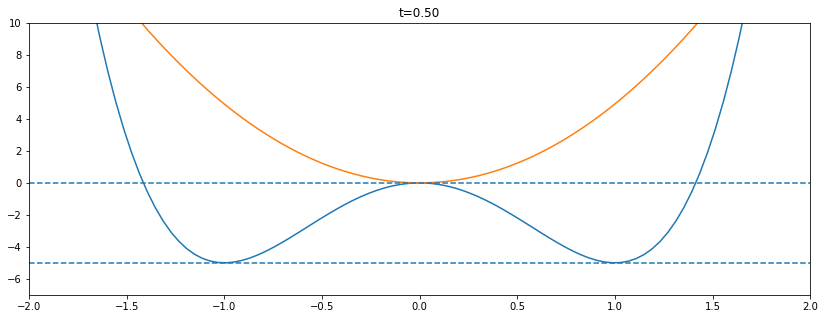

In [10]:

dom = [[-2*bfr.params['location']],[2*bfr.params['location']]]
fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(14,5))
bfr.eq_system.show_potential(0, manual_domain=dom, ax=ax)
bfr.system.show_potential(bfr.protocol.t_f/2, manual_domain=dom, ax=ax)
ax.set_ylim(-bfr.params['depth']-2,10)
ax.set_xlim(dom[0][0], dom[1][0])

ax.axhline(0, linestyle='dashed')
ax.axhline(-bfr.params['depth'], linestyle='dashed')


In [11]:
eq_mid = bfr.system.eq_state(bfr.params['N'],t=bfr.protocol.t_f/2, beta=bfr.params['beta'])


 found 5216 samples out of 5000

In [12]:
from scipy.stats import moment
for state in [ bfr.init_state[...,0], eq_mid[...,0]]:
    print(len(state), [moment(state, i+1) for i in range(4)])


5000 [array([0.]), array([0.93780128]), array([0.01288234]), array([0.98712625])]
5000 [array([0.]), array([0.10178204]), array([0.00046583]), array([0.02938302])]


[[0.515  0.4954]]


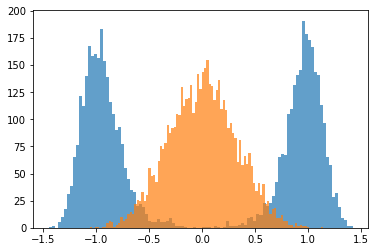

In [13]:
plt.hist(bfr.init_state[...,0], 101, alpha=.7);
plt.hist(eq_mid[...,0], bins=100, alpha=.7);
print(sum(eq_mid>0)/bfr.params['N'])


In [14]:
#tr.save_procs = [sr.SaveParams(), sr.SaveSimLight()]

In [15]:
%%time
bfr.sim.output = bfr.sim.run(verbose=True)
bfr.analyze_output()

 step 200 of 200 completeCPU times: user 1 s, sys: 53.4 ms, total: 1.06 s
Wall time: 1.14 s


In [16]:
all_state = bfr.sim.output.all_state['states']
as_plot = bfr.sim.output.as_plot['states']

final_state = bfr.sim.output.final_state
t= np.linspace(0, bfr.params['dt']*bfr.sim.nsteps, 1+bfr.sim.nsteps)
j_trajectories = bfr.sim.output.jump_trajectories
init_state = bfr.sim.initial_state
final_W = bfr.sim.output.final_W
dist = bfr.sim.output.all_state_dists['hists']
dist_z = bfr.sim.output.hist_0['hists']
dist_o = bfr.sim.output.hist_1['hists']
all_W = bfr.sim.output.all_W


In [20]:
skip = 20
histograms = dist[::skip], 
all_hists = [{'hist':dist[::skip], 'color':'tab:blue', 'ax':0},
    {'hist':dist_z[::skip], 'color':'tab:blue', 'ax':1},
    {'hist':dist_o[::skip], 'color':'tab:orange', 'ax':1}
]


In [21]:
%%capture
ani, fig, ax = kt.visualization.animate_hist_potential(all_hists, lims=[-1.5,1.5])
HTML(ani.to_jshtml(fps=30))

In [22]:
ani

In [19]:
%%capture
ah_dict = {'tab:blue':dist_z[::10], 'tab:orange':dist_o[::10]}
ani_m, fig, ax = kt.visualization.animate_hist_potential(ah_dict, lims=[-1.5,1.5], **{'alpha':.9})
HTML(ani_m.to_jshtml(fps=30))

In [20]:
ani_m

In [ ]:
%%capture
ani_1, _, _ = kt.visualization.animate_hist_potential(dist_o[::20], lims=[-1.5,1.5])
HTML(ani_1.to_jshtml(fps=30))

In [ ]:
ani_m

In [ ]:
ani_1

In [26]:
%%capture
fig, ax = plt.subplots(figsize=(10,10))
ani_as, _, _ = kt.animate_sim(as_plot[:,:,0,:],[0,1], frame_skip=5, fig_ax=[fig,ax], range=[])
HTML(ani_as.to_jshtml(fps=30))

In [27]:
ani_as

In [ ]:
t_dict =  {k:v for k,v in zip(['all_W','final_W', 'all_S'],[all_W, final_W, all_state])}
exec(f"out{int(8)}=t_dict")


In [ ]:
outs=[out8]

In [ ]:
fig, ax = plt.subplots()
for out in outs:
    fw = out['final_W']
    ax.hist(fw, bins=100, alpha=.5);
    print(fw.mean())
    ax.set_yscale('log')
    #ax.set_xlim(-5,5)
    


In [ ]:
all_W.keys()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
for item in outs:
    ax[0].plot(np.sum(item['all_S'][...,0]<0, axis=0)/len(item['all_S'][...,0]))
    #ax[0].plot(np.sum(item['all_S'][...,0]>0, axis=0)/len(item['all_S'][...,0]))
    ax[1].plot(item['all_W']['values'])
    
ax[0].legend([f'{i+1}' for i in range(len(outs))])
    

In [ ]:
j_trajectories.keys()

In [ ]:
z_jump = j_trajectories['0']
o_jump = j_trajectories['1'] 
ztrans = (z_jump>0)[:200]
otrans = (o_jump>0)[:200]

In [ ]:
as_step = bfr.sim.output.all_state['step_indices']

In [ ]:
fig, ax = plt.subplots(2)
ax[0].plot(t[as_step], all_state[ztrans,:,0,0].transpose(), alpha=.4);
ax[1].plot(t[as_step], all_state[otrans,:,0,0].transpose(), alpha=.4);


In [ ]:
lst = [out['final_W'] for out in outs]
fig, ax = plt.subplots(max(2, len(lst)), sharex=True, sharey=True, figsize=(5,10))
for i,item in enumerate(lst):

    ax[i].hist(item, bins=50, alpha=.6, density=True);
    print(np.mean(item), np.std(item))

ax[0].set_yscale('log')

In [ ]:
from scipy.stats import sem, skew, kurtosis
def get_avg_stats(work, condition=None):
    N = len(work)
    ft = np.exp(-work)
    tanh = np.tanh(work/2) 
    if condition is not None:
        cond_w = work[condition]
        Nc = len(cond_w)
        work = (Nc/N)*cond_w*(1-np.exp(-cond_w))
        ft = (Nc/N)*(1+np.exp(-cond_w))
        tanh = (Nc/N)*np.tanh(cond_w/2)*(1-np.exp(-cond_w))
        
    avg = [np.mean(work), sem(work), skew(work), kurtosis(work)]
    ft = [np.mean(ft), sem(ft)]
    avg_tanh, sem_tanh = np.mean(tanh), sem(tanh)
    emin = [ 1/avg_tanh-1, (sem_tanh/avg_tanh**2)]
    return [avg, ft, emin]

In [ ]:
from scipy.stats import sem
stats=[]
for item in [outs]:
    stats.append(get_avg_stats(item['final_W'], condition=None))

In [ ]:
zo = kt.separate_by_state(all_state[:,0,0,0])
axes = [np.s_[zo['0'], :],np.s_[zo['1'], :]]


In [ ]:
len(all_state[np.s_[zo['0'], :, 0, 0]])

In [ ]:
%%capture
ani,_,_ = kt.animate_hist_1D(all_state[...,:,0], bfr.system.protocol.t_f, which_axes=axes, frame_skip=20, lims=[-2,2])
HTML(ani.to_jshtml(fps=30))

In [ ]:
ani

In [ ]:
from scipy.interpolate import interp1d

kernel_w = .01
interp_points = 1000

init_dist = kt.kde(init_state, bandwidth=kernel_w)
x = np.linspace(np.min(init_state)-.2, np.max(init_state)+.2, interp_points)
y = init_dist.score_samples(x.reshape(-1,1))
log_pi = interp1d(x, y, kind='linear')


final_dist = kt.kde(final_state, bandwidth=kernel_w)
x = np.linspace(np.min(final_state)-.2, np.max(final_state)+.2, interp_points)
y = final_dist.score_samples(x.reshape(-1,1))
log_pf = interp1d(x, y, kind='linear')

In [ ]:
(np.exp(log_pf(x))).shape

In [ ]:
x=np.linspace(np.min(init_state),np.max(final_state),100).reshape(-1,1)
idist = np.exp(init_dist.score_samples(x))
fdist = np.exp(final_dist.score_samples(x))

fig, ax = plt.subplots(3, figsize=(10,5))
ax[0].plot(x,idist)
ax[0].hist(init_state, bins=200, density=True, alpha=.5);
ax[0].plot(x, np.exp(log_pi(x)))
ax[1].plot(x,fdist)
ax[1].hist(final_state, bins=200, density=True, alpha=.5);
ax[1].plot(x, np.exp(log_pf(x)));
ax[2].semilogy(x,np.exp(log_pi(x))[:,0]-idist);
ax[2].semilogy(x,np.exp(log_pf(x))[:,0]-fdist);


In [ ]:
log_p_i = np.array([log_pi(item) for item in init_state])[:,0]
log_p_f = np.array([log_pf(item) for item in final_state])[:,0]

In [ ]:
wm = final_W[final_W<0]
wp = final_W[final_W>0]

print((np.exp(-wm)).mean(), (len(wp)/len(wm)))
print((np.exp(-wp)).mean(),(len(wm)/(len(wp))))
print((len(wp)/len(final_W))*(np.exp(-wp)+1).mean(),(len(wm)/len(final_W))*(np.exp(-wm)+1).mean())

In [ ]:
print((np.exp(-wm)).mean(), (len(wp)/len(wm)))

In [ ]:
final_W.std()/np.sqrt(len(final_W))

In [ ]:
wp.std()/np.sqrt(len(wp))

In [ ]:
print(final_W.mean(), (len(wp)/len(final_W))*np.mean(wp*(1-np.exp(-wp))))
print(final_W.std())

In [ ]:
len(wm)

In [ ]:

print(final_W.mean(), (len(wp)/len(final_W))*np.mean(wp*(1-np.exp(-wp))))
print((len(wm)/len(final_W))*np.mean(wm*(1-np.exp(-wm))))

In [ ]:
np.exp(-final_W).mean()

In [ ]:
np.log(2)

In [ ]:
-pf*np.log(pf)- (1-pf)*np.log(1-pf)

In [ ]:
pf

In [ ]:
pf = np.sum(final_state>0)/len(final_state>0)

deltaH = -pf*np.log(pf)- (1-pf)*np.log(1-pf) - np.log(2)
print(deltaH)

In [ ]:
W_dist = kt.kde(final_W.reshape(-1,1), bandwidth=.05)
fig,ax=plt.subplots()
ax.hist(final_W, bins=50, alpha=.6, density=True);
x = np.linspace(np.min(final_W), np.max(final_W), 200).reshape(-1,1)
ax.plot(x,np.exp(W_dist.score_samples(x)))
#ax.set_yscale('log')
plt.hist(final_W, bins=100, alpha=.6, density=True);


In [ ]:
n=50
x=np.linspace(-7,7,2*n)
p = np.exp(W_dist.score_samples(x.reshape(-1,1)))

p_neg, p_pos = p[:n][::-1], p[n:]
plt.plot(x[n:], p_pos/(np.exp(x[n:])*p_neg))

In [ ]:
final_state

In [ ]:
cp

In [ ]:
cn

In [ ]:
len(final_W)

In [ ]:
nbins = 30
W_p = final_W[final_W>0]
W_n = final_W[final_W<0]
cp, bp = np.histogram(W_p, bins=np.linspace(0, max(W_p), nbins))
cn, bn = np.histogram(-W_n, bins=bp)
svals = bp[:-1]+ (bp[1]-bp[0])/2

plt.scatter(svals, (cp/(cn*np.exp(svals))))

In [ ]:
bn

In [ ]:
fig, ax =plt.subplots()
dx = bp[1]-bp[0]
ax.bar(bp[:-1], cp, align='edge', width = dx,alpha=.7)
ax.bar(-bn[:-1], cn*np.exp(svals),align='edge', width = dx, alpha=.7)
ax.set_yscale('log')

In [ ]:
sim.output

In [ ]:
sim.initia

In [ ]:
s1 = bundle_sim(final_W, system, sim)
kt.save_as_json(s1, name=f'lmda{int(lmda*10)}t{int(tf)}', dir='./t10/')

In [ ]:
sigma_old

In [ ]:
nbins = 25

c, b = np.histogram(sigma_old, bins = np.linspace(-2,2,2*nbins+1))
c_neg, c_pos = c[:nbins][::-1], c[nbins:]
svals = b[:-1]+ (b[1]-b[0])/2
svals_neg, svals_pos = svals[:nbins][::-1], svals[nbins:]
plt.plot(svals_pos, c_pos/(c_neg*np.exp(svals_pos)))


In [ ]:
plt.hist(sigma_old)

In [ ]:
sim.__dict__.keys()

In [ ]:
np.histogram(final_W)

In [ ]:
W_pos = final_W[final_W>0]
(np.tanh(W_pos/2)*(1-np.exp(-W_pos))).mean()

In [ ]:
np.tanh(final_W/2).mean()

In [ ]:
def bundle_sim(final_W, system, sim):
    out={}
    all_state=sim.output.all_state['states']
    
    W_pos = final_W[final_W > 0]
    avgs = [np.mean(final_W), np.mean(W_pos* (1-np.exp(-W_pos)))]
    std = np.std(final_W)
    hist = np.histogram(final_W, bins=50)
    hist = [item for item in hist]
    
    nbins = 25
    W_p = final_W[final_W>0]
    W_n = final_W[final_W<0]
    cp, bp = np.histogram(W_p, bins=np.linspace(0, max(W_p), nbins))
    cn, bn = np.histogram(-W_n, bins=bp)
    
    N=len(final_W)
    exp_avg = np.mean(np.exp(-final_W)) 
    tanh_avgs = [np.tanh(final_W/2).mean(), (np.tanh(W_pos/2)*(1-np.exp(-W_pos))).mean()]
    EMIN = [1/avg-1 for avg in tanh_avgs]
    params = [prot.params.tolist() for prot in system.protocol.protocols]
    sim_info = {'params':params, 'all_state':all_state, 'dur':system.protocol.t_f, 'scale':system.potential.scale }
    ft_check = {'counts_p':, 'bins_p':bp, 'counts_n':cn, 'bins_n':bn}
    keys = ['avg', 'std', 'N', 'hist', 'exp_avg', 'EMIN', 'sim', 'ft_check', 'final_state', 'init_state']
    
    init_state =  sim.initial_state
    final_state = sim.output.final_state
    
    
    values = [avgs, std, N, hist, exp_avg, EMIN, sim_info, ft_check, final_state, init_state]
    for key,value in zip(keys,values):
        print(type(value))
        if type(value) == list:
            print(type(value[0]))
            if type(value[0]) == list:
                print(type(value[0][0]))
        if type(value) == dict:
            for key, value in value.items():
                print(type(value))
        out[key] = value
    return out 

In [ ]:
for k,v in d.items():
    print(k,v)

In [ ]:
type(s1['hist'][0])

In [ ]:
x=.2334
f'x{int(x*1000)}'

In [ ]:
kt.separate_by_state(init_state)

In [ ]:
for tf in np.linspace(1,4,10):
    system.protocol.normalize()
    system.protocol.time_stretch(tf)
    
    N=500_000
    init_state = system.eq_state(N,t=0)
    
    dt = 1/2000
    tf = system.protocol.t_f
    as_step = max(1, int((tf/dt)/500))
    procs = [
            sp.ReturnFinalState(),
            sp.MeasureAllState(trial_request=np.s_[:500],step_request=np.s_[::as_step])]

    sim = setup_sim(system, init_state, damping=1, temp=1, dt=dt, procedures=procs)
    sim.output = sim.run(verbose=True)
        
    all_state = sim.output.all_state['states']
    final_state = sim.output.final_state
    
    W0 = system.get_potential(init_state, .1) - system.get_potential(init_state, 0)
    w1 = system.get_potential(final_state, system_protocol.t_f) - system.get_potential(final_state, system.protocol.t_f-.1)
    final_W = W0 + W1

        
    s1 = bundle_sim(final_W, system, sim.output)
    kt.save_as_json(s1, name=f't{int(100*tf)}', dir='./t11/')

In [ ]:
ds = [kt.open_json(item) for item in kt.file_list('./t11/')]

In [ ]:
bnds=[ item['bounds'] for item in ds]
sgma = [item['avg'] for item in ds]
scl = [item['sim']['dur'] for item in ds]
var =  [item['std'] for item in ds]
e_avg = [item['exp_avg'] for item in ds]

In [ ]:
scl

In [ ]:
var

In [ ]:
[bound['HG'] for bound in bnds]

In [ ]:
fig, ax = plt.subplots()
for item in ['HG', 'HVV', 'TGGL', 'EMIN']:
    ax.scatter(var, [bound[item] for bound in bnds], label=item)
ax.legend()

In [ ]:
plt.hist(ds[0]['hist']);

In [ ]:
len(h[1])

In [ ]:
fig, ax = plt.subplots()
h = ds[-2]['hist']
dx = h[1][1]-h[1][0]
ax.bar(np.add(h[1][:-1],dx), h[0])
ax.set_yscale('log')


In [ ]:
(item['sim']['scale'])

In [ ]:
sgma

In [ ]:
plt.scatter(scl,sgma)